# Importing Necessary Libraries

In [1]:
#Notebook adapted from https://github.com/ArmandDS/bert_for_long_text

import pandas as pd
import numpy as np
np.random.seed(1337)
from keras import Sequential
from keras.utils import Sequence
from keras.layers import LSTM, Dense, Masking
import numpy as np
import keras
from keras.utils import np_utils
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Embedding, Dense, Input, concatenate, Layer, Lambda, Dropout, Activation
import datetime
from datetime import datetime
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, TensorBoard
import tensorflow as tf


from cleantext import clean
import pickle
import string


import os
import csv
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import codecs
from os import path

import ktrain
from ktrain import text


Using TensorFlow backend.


using Keras version: 2.2.4-tf


# Preprocessing text

Preprocessing data in a dataframe file with host,text,text_label,num_label

In [ ]:
Train_data = pd.DataFrame()
# Read training data
with open("train.csv", 'r') as f:
    train_data = f.read().splitlines()

train_hosts = list()
y_train = list()
for row in train_data:
    host, label = row.split(",")
    train_hosts.append(host)
    y_train.append(label.lower())



# Load the textual content of a set of webpages for each host into the dictionary "text". 
# The encoding parameter is required since the majority of our text is french.
texts = dict()
filenames = os.listdir('text/text')
for filename in filenames:
    with codecs.open(path.join('text/text/', filename),'r', encoding="utf8", errors = 'ignore') as f: 
        texts[filename] = f.read().replace("\n", "").lower()
        #print(f.read().replace("\n", "").lower())
    

train_data = list()
for host in train_hosts:
    if host in texts:
        train_data.append(texts[host])
    else:
        train_data.append('')

classes = ['business/finance','education/research','entertainment','health/medical','news/press','politics/government/law','sports','tech/science']
classes_to_label = {'business/finance' : 0,'education/research':1,'entertainment':2,'health/medical':3,'news/press':4,
'politics/government/law':5,'sports':6,'tech/science' : 7}
y_train_num = [classes_to_label[i] for i in y_train]

Train_data['host'] = train_hosts
Train_data['text'] = train_data
Train_data['label_text'] = y_train
Train_data['label_num'] = y_train_num

In [ ]:
Train_data

In [ ]:
Train_data.to_pickle('Train_data')
Train_data.to_csv('Train_data.csv')

In [ ]:
Test_data = pd.DataFrame()
# Read test data
with open("test.csv", 'r') as f:
    test_hosts = f.read().splitlines()
    
# Get textual content of web hosts of the test set
test_data = list()
for host in test_hosts:
    if host in texts:
        test_data.append(texts[host])
    else:
        test_data.append('')

In [ ]:
Test_data['host'] = test_hosts
Test_data['text'] = test_data

Test_data.to_pickle('test_data')
Test_data.to_csv('test_data.csv')

In [ ]:
Test_data

# Loading The Data

In [2]:
train_raw = pd.read_pickle('Train_data')
test_raw = pd.read_pickle('Test_data')
train_raw.head()

,host,text,label_text,label_num
0,9032,#polepharma » flux polepharma » flux des co...,health/medical,3
1,5346,301 moved permanen...,entertainment,2
2,18778,(button) fermer en poursuivant votre navi...,entertainment,2
3,11939,#hal (button) toggle navigation ccsd ...,education/research,1
4,17502,user-agent: * disallow: disallow: /publishe...,tech/science,7


In [3]:
print(train_raw.shape)
print(test_raw.shape)

(2125, 4)
(560, 2)


# Preprocessing Data

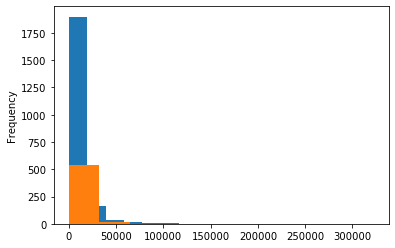

In [4]:
train_raw.text.apply(lambda x: len(x.split())).plot(kind='hist')
test_raw.text.apply(lambda x: len(x.split())).plot(kind='hist')

In [5]:
train_raw['len_txt'] = train_raw.text.apply(lambda x: len(x.split()))
test_raw['len_txt'] = train_raw.text.apply(lambda x: len(x.split()))
train_raw.describe()

,label_num,len_txt
count,2125.000000,2125.000000
mean,2.485176,7800.792941
std,2.418423,14526.236363
min,0.000000,0.000000
25%,0.000000,1053.000000
50%,2.000000,3043.000000
75%,5.000000,8487.000000
max,7.000000,194304.000000


In [6]:
print(train_raw.shape)
print(test_raw.shape)

(2125, 5)
(560, 3)


Select only the row with number of words greater than 250: maybe ?

In [7]:
train_raw = train_raw[['host','text', 'label_text']]
train_raw.reset_index(inplace=True, drop=True)
train_raw.head()

,host,text,label_text
0,9032,#polepharma » flux polepharma » flux des co...,health/medical
1,5346,301 moved permanen...,entertainment
2,18778,(button) fermer en poursuivant votre navi...,entertainment
3,11939,#hal (button) toggle navigation ccsd ...,education/research
4,17502,user-agent: * disallow: disallow: /publishe...,tech/science


Group similar products

In [8]:
for l in np.unique(train_raw['label_text']):
  print(l)

business/finance
education/research
entertainment
health/medical
news/press
politics/government/law
sports
tech/science


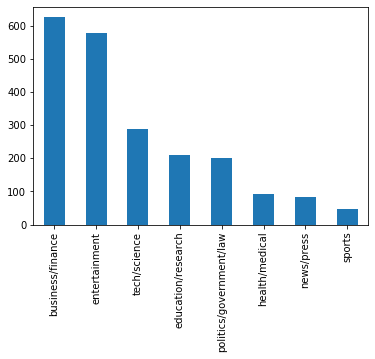

In [9]:
train_raw['label_text'].value_counts().sort_values(ascending=False).plot(kind='bar')

In [10]:
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
train_raw['label'] = LE.fit_transform(train_raw['label_text'])
train_raw.head()

,host,text,label_text,label
0,9032,#polepharma » flux polepharma » flux des co...,health/medical,3
1,5346,301 moved permanen...,entertainment,2
2,18778,(button) fermer en poursuivant votre navi...,entertainment,2
3,11939,#hal (button) toggle navigation ccsd ...,education/research,1
4,17502,user-agent: * disallow: disallow: /publishe...,tech/science,7


In [11]:
len(np.unique(train_raw['label']))

8

In [12]:
train = train_raw.copy()
test = test_raw.copy()

In [13]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(train, test_size=0.1, random_state=35)
train.head()

,host,text,label_text,label
1847,7587,aller au contenu principal (button) ouvri...,business/finance,0
357,16150,fort young hotel * overview * rooms...,entertainment,2
1827,9841,301moved permanently the document has been p...,business/finance,0
1879,6441,#alternate alternate alternate alternate a...,business/finance,0
522,8533,#rss * [750g_influenceurs.png] * __...,entertainment,2


In [14]:
train.reset_index(drop=True, inplace=True)
train.head(2)

,host,text,label_text,label
0,7587,aller au contenu principal (button) ouvri...,business/finance,0
1,16150,fort young hotel * overview * rooms...,entertainment,2


In [15]:
val.reset_index(drop=True, inplace=True)
val.head(2)

,host,text,label_text,label
0,13528,#extranet icp rss aller au contenu princi...,politics/government/law,5
1,3604,iframe: https://www.googletagmanager.com/ns...,entertainment,2


In [16]:
print("Training Set Shape :", train.shape)
print("Validation Set Shape :", val.shape)

DATA_COLUMN = 'text'
LABEL_COLUMN = 'label_text'
# The list containing all the classes (train['SECTION'].unique())
label_list = [x for x in np.unique(train.label_text)]
print(label_list)

Training Set Shape : (1912, 4)
Validation Set Shape : (213, 4)
['business/finance', 'education/research', 'entertainment', 'health/medical', 'news/press', 'politics/government/law', 'sports', 'tech/science']


# Splitting the Data into smaller chunks

In [17]:
def get_split(text1):
  l_total = []
  l_parcial = []
  if len(text1.split())//150 >0:
    n = len(text1.split())//150
  else: 
    n = 1
  for w in range(n):
    if w == 0:
      l_parcial = text1.split()[:200]
      l_total.append(" ".join(l_parcial))
    else:
      l_parcial = text1.split()[w*150:w*150 + 200]
      l_total.append(" ".join(l_parcial))
  return l_total

In [18]:
train['text_split'] = train[DATA_COLUMN].apply(get_split)
train.head()

,host,text,label_text,label,text_split
0,7587,aller au contenu principal (button) ouvri...,business/finance,0,[aller au contenu principal (button) ouvrir le...
1,16150,fort young hotel * overview * rooms...,entertainment,2,[fort young hotel * overview * rooms * dining ...
2,9841,301moved permanently the document has been p...,business/finance,0,[301moved permanently the document has been pe...
3,6441,#alternate alternate alternate alternate a...,business/finance,0,[#alternate alternate alternate alternate alte...
4,8533,#rss * [750g_influenceurs.png] * __...,entertainment,2,[#rss * [750g_influenceurs.png] * ____________...


In [19]:
val['text_split'] = val[DATA_COLUMN].apply(get_split)
val.head(2)

,host,text,label_text,label,text_split
0,13528,#extranet icp rss aller au contenu princi...,politics/government/law,5,[#extranet icp rss aller au contenu principalh...
1,3604,iframe: https://www.googletagmanager.com/ns...,entertainment,2,[iframe: https://www.googletagmanager.com/ns.h...


In [20]:
test['text_split'] = test[DATA_COLUMN].apply(get_split)
train_raw['text_split'] = train_raw[DATA_COLUMN].apply(get_split)



In [21]:
test.to_pickle("split_test")
train_raw.to_pickle("split_train")

In [22]:
train_l = []
label_l = []
index_l =[]
for idx,row in train.iterrows():
  for l in row['text_split']:
    train_l.append(l)
    label_l.append(row['label'])
    index_l.append(idx)
len(train_l), len(label_l), len(index_l)

(96119, 96119, 96119)

In [23]:
val_l = []
val_label_l = []
val_index_l = []
for idx,row in val.iterrows():
  for l in row['text_split']:
    val_l.append(l)
    val_label_l.append(row['label'])
    val_index_l.append(idx)
len(val_l), len(val_label_l), len(val_index_l)

(13555, 13555, 13555)

In [24]:
test_l = []
test_index_l = []
for idx,row in test.iterrows():
  for l in row['text_split']:
    test_l.append(l)
    test_index_l.append(idx)
len(test_l), len(test_index_l)

(28229, 28229)

In [25]:
train_raw_l = []
label_raw_l = []
index_raw_l =[]
for idx,row in train_raw.iterrows():
  for l in row['text_split']:
    train_raw_l.append(l)
    label_raw_l.append(row['label'])
    index_raw_l.append(idx)
len(train_raw_l), len(label_raw_l), len(index_raw_l)

(109674, 109674, 109674)

The final dataset for training:

In [26]:
train_df = pd.DataFrame({DATA_COLUMN:train_l, LABEL_COLUMN:label_l})
train_df.head()

,text,label_text
0,aller au contenu principal (button) ouvrir le ...,0
1,1. accueilinitiatives associations : comment b...,0
2,en savoir plus sur salon de l'étudiant paris 1...,0
3,lien s'ouvre dans une nouvelle fenêtre) * en v...,0
4,la page d'accueil du site publicnavigation sec...,0


In [27]:
val_df = pd.DataFrame({DATA_COLUMN:val_l, LABEL_COLUMN:val_label_l})
val_df.head()

,text,label_text
0,#extranet icp rss aller au contenu principalho...,5
1,iframe: https://www.googletagmanager.com/ns.ht...,2
2,+ bas-rhin + haut-rhin + chuchotements + courr...,2
3,gilets jaunes + affaire reiser + attentat du 1...,2
4,"été dénoncé par un proche arrêté en écosse, du...",2


In [28]:
test_df = pd.DataFrame({DATA_COLUMN:test_l})
test_df.head()

,text
0,iframe: //www.googletagmanager.com/ns.html?id=...
1,self. scroll down mind expansive thinking deve...
2,service close faith & service no matter what y...
3,and conservation. quad canisius jumps four spo...
4,iframe: https://www.googletagmanager.com/ns.ht...


In [29]:
train_raw_df = pd.DataFrame({DATA_COLUMN:train_raw_l, LABEL_COLUMN:label_raw_l})
train_raw_df.head()

,text,label_text
0,#polepharma » flux polepharma » flux des comme...,3
1,territoires + région centre-val de loire + rég...,3
2,octobre 2019 à biocitech (romainville-grand pa...,3
3,"de thierry ziegler, head of manufacturing de c...",3
4,européens... > lire la suite * comprendre les ...,3


# Distilbert Training

Process the data for BERT

In [30]:
import transformers
Model_Name = 'distilbert-base-multilingual-cased'
import ktrain
from ktrain import text
classes = ['business/finance','education/research','entertainment','health/medical','news/press','politics/government/law','sports','tech/science']
t = text.Transformer(Model_Name, maxlen = 511, classes = classes)



In [40]:
tokenizer = transformers.DistilBertTokenizer.from_pretrained(Model_Name)

In [108]:
trn = t.preprocess_train(train_l, label_l) 
vali = t.preprocess_test(val_l, val_label_l)

preprocessing train...
language: fr
train sequence lengths:
	mean : 200
	95percentile : 200
	99percentile : 200


preprocessing test...
language: fr
test sequence lengths:
	mean : 200
	95percentile : 200
	99percentile : 200


In [109]:
input_ids = tf.constant(tokenizer.encode("Hello, my dog is cute", add_special_tokens=True))[None, :]

In [110]:
input_ids

<tf.Tensor: shape=(1, 9), dtype=int32, numpy=array([[  101, 31178,   117, 15127, 17835, 10124, 21610, 10112,   102]])>

In [111]:

pickle.dump( trn, open( 'trainsplit.p', "wb" ) )
pickle.dump( val, open( 'validationsplit.p', "wb" ) )

In [112]:
trn[0]

(array([[[  101,   164, 66758, ...,     0,     0,     0],
         [    1,     1,     1, ...,     0,     0,     0],
         [    0,     0,     0, ...,     0,     0,     0]]]),
 array([[0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32))

In [31]:
model = t.get_classifier()


In [114]:
model.layers[0].trainable = False
model.layers[3].rate = 0.2
learner = ktrain.get_learner(model,train_data=trn, val_data = vali, batch_size=6)

In [115]:
learner.fit_onecycle(0.0001, 4,checkpoint_folder='/save/')



begin training using onecycle policy with max lr of 0.0001...
Train for 16684 steps, validate for 1568 steps
Epoch 1/4
16684/16684 [==============================] - 2969s 178ms/step - loss: 1.5068 - accuracy: 0.4444 - val_loss: 1.3304 - val_accuracy: 0.5053
Epoch 2/4
16684/16684 [==============================] - 2975s 178ms/step - loss: 1.2487 - accuracy: 0.5404 - val_loss: 1.3856 - val_accuracy: 0.4859
Epoch 3/4
16684/16684 [==============================] - 2980s 179ms/step - loss: 1.1578 - accuracy: 0.5707 - val_loss: 1.2558 - val_accuracy: 0.5276
Epoch 4/4
16684/16684 [==============================] - 2980s 179ms/step - loss: 1.0968 - accuracy: 0.5945 - val_loss: 1.2527 - val_accuracy: 0.5178


In [116]:
model.layers[0].trainable = True
model.layers[3].rate = 0.2
learner = ktrain.get_learner(model,train_data=trn, val_data = vali, batch_size=6)

In [117]:
learner.fit_onecycle(0.00005, 20,checkpoint_folder='/usave/')



begin training using onecycle policy with max lr of 5e-05...
Train for 16684 steps, validate for 1568 steps
Epoch 1/20
16684/16684 [==============================] - 2991s 179ms/step - loss: 1.0755 - accuracy: 0.6037 - val_loss: 1.2560 - val_accuracy: 0.5152
Epoch 2/20
16684/16684 [==============================] - 2982s 179ms/step - loss: 1.0725 - accuracy: 0.6044 - val_loss: 1.2707 - val_accuracy: 0.4938
Epoch 3/20
16684/16684 [==============================] - 2984s 179ms/step - loss: 1.0623 - accuracy: 0.6091 - val_loss: 1.2547 - val_accuracy: 0.5233
Epoch 4/20
16684/16684 [==============================] - 2985s 179ms/step - loss: 1.0541 - accuracy: 0.6121 - val_loss: 1.2446 - val_accuracy: 0.5329
Epoch 5/20
16684/16684 [==============================] - 2984s 179ms/step - loss: 1.0421 - accuracy: 0.6165 - val_loss: 1.2735 - val_accuracy: 0.4994
Epoch 6/20
16684/16684 [==============================] - 2983s 179ms/step - loss: 1.0286 - accuracy: 0.6208 - val_loss: 1.2291 - val_a

KeyboardInterrupt: 

In [118]:
model.save_pretrained('/usave/')

In [57]:
model(input_ids)

(<tf.Tensor: shape=(1, 8), dtype=float32, numpy=
 array([[ 2.1930883 , -0.84207124,  4.422745  , -3.8641634 , -0.86248827,
         -6.315142  , -5.8191185 , -2.4697618 ]], dtype=float32)>,)

In [52]:
model.compile(loss = 'categorical_crossentropy')
predictor = ktrain.get_predictor(model, preproc = t)

In [53]:
predictor.explain(train_l[0][:200])

In [54]:
label_l[0]

0

# BERT: Get The Vector Transformations from the Fine Tuned BERT

In [42]:
model = model.from_pretrained('/usave/') # get the best model from the last part
tokenizer = transformers.DistilBertTokenizer.from_pretrained(Model_Name)

In [43]:
train_df

,text,label_text
0,aller au contenu principal (button) ouvrir le ...,0
1,1. accueilinitiatives associations : comment b...,0
2,en savoir plus sur salon de l'étudiant paris 1...,0
3,lien s'ouvre dans une nouvelle fenêtre) * en v...,0
4,la page d'accueil du site publicnavigation sec...,0
...,...,...
96114,o wide widths o sale footwear + clothing shop ...,0
96115,shoes o sale footwear + clothing shop all clot...,0
96116,+ women's pro shop all women's pro o work boot...,0
96117,workwear o sale clothing + women's shop all wo...,0


In [48]:
train_df['label_text'][1000]

2

In [49]:
def get_feature(text):
    input_ids = tf.constant(tokenizer.encode(text, add_special_tokens=True, max_length=511))[None, :]  # Batch size 1
    distilbert_output = model.distilbert(input_ids)
    hidden_state = distilbert_output[0]  # (bs, seq_len, dim)
    pooled_output = hidden_state[:, 0]  # (bs, dim)
    pooled_output = model.pre_classifier(pooled_output)  # (bs, dim)
    
    
    return pooled_output[0,:]

# A method to get predictions
def getPrediction(in_sentences, type_output = "features"):
  #A list to map the actual labels to the predictions
    
    
    return [get_feature(text) for text in in_sentences ]


In [50]:
train_df.shape, val_df.shape, test_df.shape

((96119, 2), (13555, 2), (28229, 1))

Now extracting the representations: This can take a while

In [51]:
%%time
tr_emb = np.apply_along_axis(getPrediction, 0,np.array(train_df[DATA_COLUMN]))


Wall time: 6h 4min 37s


In [52]:
%%time
val_emb = np.apply_along_axis(getPrediction, 0,np.array(val_df[DATA_COLUMN]))
val_emb.shape

Wall time: 52min 44s


(13555, 768)

In [53]:
%%time
test_emb = np.apply_along_axis(getPrediction, 0,np.array(test_df[DATA_COLUMN]))
test_emb.shape

Wall time: 1h 46min 30s


(28229, 768)

In [54]:
val_emb.shape, tr_emb.shape,test_emb.shape

((13555, 768), (96119, 768), (28229, 768))

and make the dataset for train and val:

In [55]:
aux = -1
len_l = 0
train_x = {}
for l, emb in zip(index_l, tr_emb):
  if l in train_x.keys():
    train_x[l]  =np.vstack([train_x[l], emb])
  else:
    train_x[l] = [emb]

len(train_x.keys())


1912

In [56]:
train_l_final = []
label_l_final = []
train_host_final = []
for k in train_x.keys():
    train_l_final.append(train_x[k])
    label_l_final.append(train.loc[k]['label'])
    train_host_final.append(train.loc[k]['host'])


df_train = pd.DataFrame({'emb': train_l_final, 'label': label_l_final,'host' : train_host_final })
df_train.head()

,emb,label,host
0,"[[0.06988406, 0.03695625, -0.1680417, 0.058633...",0,7587
1,"[[0.13269949, 0.08223928, 0.068089694, 0.00742...",2,16150
2,"[[0.037531834, -0.024001539, -0.10459307, 0.27...",0,9841
3,"[[0.004611317, -0.013208538, 0.063222826, 0.16...",0,6441
4,"[[0.19781485, -0.08122094, -0.011644304, 0.184...",2,8533


In [57]:
df_train.to_pickle("train_emb_transfo_final")

In [58]:
aux = -1
len_l = 0
val_x = {}

for l, emb in zip(val_index_l, val_emb):
    if l in val_x.keys():
        val_x[l]  =np.vstack([val_x[l], emb])
    else:
        val_x[l] = [emb]


val_l_final = []
vlabel_l_final = []
val_host_final = []
for k in val_x.keys():
    val_l_final.append(val_x[k])
    vlabel_l_final.append(val.loc[k]['label'])
    val_host_final.append(val.loc[k]['host'])

df_val = pd.DataFrame({'emb': val_l_final, 'label': vlabel_l_final,'host':val_host_final })
df_val.head()

,emb,label,host
0,"[[0.2707724, -0.1408167, 0.026115954, 0.068481...",5,13528
1,"[[0.21368726, -0.3230019, 0.085532635, 0.24895...",2,3604
2,"[[0.22465613, -0.15649086, -0.07135987, 0.0697...",0,5169
3,"[[0.2935127, 0.020120755, -0.15960655, 0.08097...",0,16968
4,"[[0.14495626, -0.045760974, -0.07624662, 0.157...",2,21379


In [59]:
df_val.to_pickle('val_emb_transfo_final')

In [60]:
aux = -1
len_l = 0
test_x = {}

for l, emb in zip(test_index_l, test_emb):
    if l in test_x.keys():
        test_x[l]  =np.vstack([test_x[l], emb])
    else:
        test_x[l] = [emb]


test_l_final = []
test_host_final = []

for k in test_x.keys():
    test_l_final.append(test_x[k])
    test_host_final.append(test.loc[k]['host'])
    

df_test = pd.DataFrame({'emb': test_l_final,'host' : test_host_final })
df_test.head()

,emb,host
0,"[[0.076327555, 0.012821771, 0.06977114, -0.003...",27997
1,"[[0.21038389, -0.1938399, 0.17642684, 0.288926...",9316
2,"[[0.26858386, 0.038725607, 0.10285851, 0.15176...",27045
3,"[[0.08154934, -0.025535166, 0.20253053, 0.0794...",19805
4,"[[0.22604373, 0.049032286, -0.04127267, 0.0389...",26580


In [61]:
df_test.to_pickle('test_emb_transfo_final')

In [ ]:
aux = -1
len_l = 0
train_raw_x = {}
for l, emb in zip(index_raw_l, train_raw_emb):
  if l in train_raw_x.keys():
    train_x[l]  =np.vstack([train_raw_x[l], emb])
  else:
    train_x[l] = [emb]

len(train_raw_x.keys())

train_raw_l_final = []
label_raw_l_final = []
train_raw_host_final = []

for k in train_raw_x.keys():
    train_raw_l_final.append(train_raw_x[k])
    label_raw_l_final.append(train_raw.loc[k]['label'])
    train_raw_host_final.append(train_raw.loc[k]['host'])


df_train_raw = pd.DataFrame({'emb': train_raw_l_final, 'label': label_raw_l_final,'host' : train_raw_host_final })
df_train_raw.head()

In [ ]:
df_train_raw.to_pickle('train_raw_emb_final')

# LSTM: Creating the Final Model

In [8]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import numpy as np
import pandas as pd
from keras import regularizers
import tensorflow as tf

label_list = ['business/finance','education/research','entertainment','health/medical','news/press','politics/government/law','sports','tech/science']

text_input = layers.Input(shape=(None,768,), dtype='float32', name='text')

l_mask = layers.Masking(mask_value=-99.)(text_input)
# Which we encoded in a single vector via a LSTM
encoded_text = layers.LSTM(500)(l_mask) #dropout = 0.2

drop_lstm = layers.Dropout(0.1)(encoded_text)
out_dense1 = layers.Dense(1000, activation='relu',name = 'pre_features',kernel_regularizer=regularizers.l2(0.000) )(drop_lstm)
drop2 = layers.Dropout(0.1)(out_dense1)

features = layers.Dense(30, activation='relu',name = 'features',kernel_regularizer=regularizers.l2(0.000) )(drop2)
drop3 = layers.Dropout(0)(features)
# And we add a softmax classifier on top
out = layers.Dense(len(label_list), activation='softmax')(drop3)
# At model instantiation, we specify the input and the output:
model = Model(text_input, out)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text (InputLayer)            [(None, None, 768)]       0         
_________________________________________________________________
masking_1 (Masking)          (None, None, 768)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 500)               2538000   
_________________________________________________________________
dropout_3 (Dropout)          (None, 500)               0         
_________________________________________________________________
pre_features (Dense)         (None, 1000)              501000    
_________________________________________________________________
dropout_4 (Dropout)          (None, 1000)              0         
_________________________________________________________________
features (Dense)             (None, 30)                3003

In [2]:
# Load embedding from bert

df_train = pd.read_pickle('train_emb_transfo_final')
df_val  = pd.read_pickle('val_emb_transfo_final')
df_test = pd.read_pickle('test_emb_transfo_final')

df_train.shape, df_val.shape, df_test.shape

((1912, 3), (213, 3), (560, 2))

In [3]:
df_val

,emb,label,host
0,"[[0.2707724, -0.1408167, 0.026115954, 0.068481...",5,13528
1,"[[0.21368726, -0.3230019, 0.085532635, 0.24895...",2,3604
2,"[[0.22465613, -0.15649086, -0.07135987, 0.0697...",0,5169
3,"[[0.2935127, 0.020120755, -0.15960655, 0.08097...",0,16968
4,"[[0.14495626, -0.045760974, -0.07624662, 0.157...",2,21379
...,...,...,...
208,"[[0.05342447, 0.11145939, -0.18104503, 0.03401...",2,23548
209,"[[-0.012084671, 0.11048345, 0.11110841, 0.1150...",5,4866
210,"[[0.0316687, 0.013325065, -0.28295845, 0.06511...",3,11223
211,"[[0.18961461, -0.01935073, -0.06491029, 0.0559...",7,17199


The generator functions:

In [4]:
num_sequences = len(df_train['emb'].to_list())
batch_size = 4
batches_per_epoch =  int(478)
#assert batch_size * batches_per_epoch == num_sequences
num_features= 768
def train_generator(df):
    x_list= df['emb'].to_list()
    y_list =  df.label.to_list()
    # Generate batches
    while True:
        for b in range(batches_per_epoch):
            longest_index = (b + 1) * batch_size - 1
            timesteps = len(max(df['emb'].to_list()[:(b + 1) * batch_size][-batch_size:], key=len))
            x_train = np.full((batch_size, timesteps, num_features), -99.)
            y_train = np.zeros((batch_size,  1))
            for i in range(batch_size):
                li = b * batch_size + i
                x_train[i, 0:len(x_list[li]), :] = x_list[li]
                y_train[i] = y_list[li]
            yield x_train, y_train

In [5]:
num_sequences_val = len(df_val['emb'].to_list())
batch_size_val = 3
batches_per_epoch_val = 71
assert batch_size_val * batches_per_epoch_val == num_sequences_val
num_features= 768
def val_generator(df):
    x_list= df['emb'].to_list()
    y_list =  df.label.to_list()
    # Generate batches
    while True:
        for b in range(batches_per_epoch_val):
            longest_index = (b + 1) * batch_size_val - 1
            timesteps = len(max(df['emb'].to_list()[:(b + 1) * batch_size_val][-31:], key=len))
            # print(len(df_train['emb'].to_list()[:b+batch_size][-7:]))
            x_train = np.full((batch_size_val, timesteps, num_features), -99.)
            y_train = np.zeros((batch_size_val,  1))
            for i in range(batch_size_val):
                li = b * batch_size_val + i
                # print("li", li)
                # print(x_train[i, 0:len(x_list[li]), :].shape, len(x_list[li]))
                x_train[i, 0:len(x_list[li]), :] = x_list[li]
                y_train[i] = y_list[li]
            yield x_train, y_train

# LSTM Final Model: Training

In [9]:
from keras.callbacks import ReduceLROnPlateau,EarlyStopping,TensorBoard
from keras.callbacks.callbacks import ModelCheckpoint


filepath = 'lstm_save/weights.{epoch:02d}-{val_loss:.2f}.hdf5'

check = tf.keras.callbacks.ModelCheckpoint(
    filepath, monitor='val_loss', verbose=1, save_best_only=True,
    save_weights_only=True, mode='auto', save_freq='epoch' )



tensorb = TensorBoard(
    log_dir='logs', histogram_freq=0, write_graph=True, write_images=False,
    update_freq='epoch', profile_batch=2, embeddings_freq=0,
    embeddings_metadata=None,
)

stop = EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto',
    baseline=None, restore_best_weights=False
)

call_reduce = ReduceLROnPlateau(monitor='loss', factor=0.95, patience=3, verbose=2,
                                mode='auto', min_delta=0.01, cooldown=0, min_lr=0)

In [10]:


model.fit_generator(train_generator(df_train), steps_per_epoch=batches_per_epoch, epochs=100,
                    validation_data=val_generator(df_val), validation_steps=batches_per_epoch_val, callbacks =[call_reduce,stop,check,tensorb],workers=1, use_multiprocessing=False )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 478 steps, validate for 71 steps
Epoch 1/100
477/478 [============================>.] - ETA: 0s - loss: 1.8327 - acc: 0.2704
Epoch 00001: val_loss improved from inf to 1.69896, saving model to lstm_save/weights.01-1.70.hdf5
478/478 [==============================] - 15s 32ms/step - loss: 1.8319 - acc: 0.2704 - val_loss: 1.6990 - val_acc: 0.3568
Epoch 2/100
477/478 [============================>.] - ETA: 0s - loss: 1.7543 - acc: 0.3218
Epoch 00002: val_loss improved from 1.69896 to 1.66086, saving model to lstm_save/weights.02-1.66.hdf5
478/478 [==============================] - 11s 23ms/step - loss: 1.7537 - acc: 0.3217 - val_loss: 1.6609 - val_acc: 0.3850
Epoch 3/100
477/478 [============================>.] - ETA: 0s - loss: 1.6909 - acc: 0.3433
Epoch 00003: val_loss improved from 1.66086 to 1.57851, saving model to lstm_save/weights.03-1.58.hdf5
478/478 [==============================] - 11s 23ms/step - loss: 1.6898 - acc: 0

# LSTM Final Model: Evaluation



In [75]:
model.load_weights("lstm_save/weights.05-1.10.hdf5") # load one of the best model


In [69]:
df_test

,emb,host
0,"[[0.0, 0.0, 0.23700431, 0.0, 0.0, 0.0, 0.24596...",27997
1,"[[0.23384675, 0.0, 0.5803098, 0.0, 0.0, 0.0, 0...",9316
2,"[[0.0, 0.12591366, 0.19137713, 0.21386047, 0.0...",27045
3,"[[0.0, 0.2413576, 0.3700843, 0.31157365, 0.131...",19805
4,"[[0.0, 0.0, 0.0, 0.0, 0.16975042, 0.0, 0.0, 0....",26580
...,...,...
555,"[[0.0, 0.37172377, 0.0, 0.0, 0.4010087, 0.0, 0...",23783
556,"[[0.15940695, 0.015464779, 0.38735297, 0.02623...",16792
557,"[[0.0, 0.0, 0.43690214, 0.0, 0.0, 0.0, 0.0, 0....",6584
558,"[[0.0, 0.01775385, 0.0568979, 0.0, 0.0, 0.0, 0...",13527


In [10]:
import csv
classes = ['business/finance','education/research','entertainment','health/medical','news/press','politics/government/law','sports','tech/science']

# Write predictions to a file
with open('lstm_bert2.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    lst = classes
    lst.insert(0, "Host")
    writer.writerow(lst)
    for k in range(len(df_test)):
        if len(df_test.emb[k]) == 1: # avoid a non expected error
            lst = list(model.predict(tf.convert_to_tensor(df_test.emb[k][0][None,None,:]))[0])   
        else : 
            lst = list(model.predict(tf.convert_to_tensor(df_test.emb[k][None,:]))[0])
        lst.insert(0, df_test.host[k])
        writer.writerow(lst)

In [101]:
df_test.host

0      27997
1       9316
2      27045
3      19805
4      26580
       ...  
555    23783
556    16792
557     6584
558    13527
559      434
Name: host, Length: 560, dtype: object

# Final embedding for the graph method

In [86]:


layer_name = 'features'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)



emb_list = []
host_list = []
label_list = []
mask_list = []

df_train.emb
df_test.emb

for k in range(len(df_train)):
    if len(df_train.emb[k]) == 1: # avoid a non expected error
        emb = intermediate_layer_model.predict(tf.convert_to_tensor(df_train.emb[k][0][None,None,:]))[0] 
    else : 
        emb = intermediate_layer_model.predict(tf.convert_to_tensor(df_train.emb[k][None,:]))[0]
    
    emb_list.append(emb)
    host_list.append(df_train.host[k])
    label_list.append(df_train.label[k])
    mask_list.append(0)
    
for k in range(len(df_val)):
    if len(df_val.emb[k]) == 1: # avoid a non expected error
        emb = intermediate_layer_model.predict(tf.convert_to_tensor(df_val.emb[k][0][None,None,:]))[0] 
    else : 
        emb = intermediate_layer_model.predict(tf.convert_to_tensor(df_val.emb[k][None,:]))[0]
    
    emb_list.append(emb)
    host_list.append(df_val.host[k])
    label_list.append(df_val.label[k])
    mask_list.append(1)
    

for k in range(len(df_test)):
    if len(df_test.emb[k]) == 1: # avoid a non expected error
        emb = intermediate_layer_model.predict(tf.convert_to_tensor(df_test.emb[k][0][None,None,:]))[0]  
    else : 
        emb = intermediate_layer_model.predict(tf.convert_to_tensor(df_test.emb[k][None,:]))[0]
    
    emb_list.append(emb)
    host_list.append(df_test.host[k])
    label_list.append(-1)
    mask_list.append(-1)

    
df_graph_method = pd.DataFrame({'emb': emb_list, 'label': label_list,'host' :host_list, 'mask' : mask_list })
df_graph_method.to_pickle('emb__for_graph_method')

In [78]:
df_graph_method

,emb,label,host,mask
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.06704821, 0.0, 0.0...",0,7587,0
1,"[0.0, 0.0, 0.0, 0.65032977, 0.0, 1.2268757, 0....",2,16150,0
2,"[0.0, 0.0, 0.0, 0.7029427, 0.0, 0.014290629, 0...",0,9841,0
3,"[0.0, 0.0, 0.0, 1.7263325, 0.0, 1.8023202, 0.0...",0,6441,0
4,"[0.0, 0.0, 0.0, 0.6054661, 0.0, 1.9374746, 0.0...",2,8533,0
...,...,...,...,...
2680,"[0.0, 0.0, 0.0, 1.6931992, 0.0, 2.2609165, 0.0...",-1,23783,-1
2681,"[0.0, 0.0, 0.0, 1.0591748, 0.0, 0.6423409, 0.0...",-1,16792,-1
2682,"[0.0, 0.0, 0.0, 0.6837437, 0.0, 0.7264668, 0.0...",-1,6584,-1
2683,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.5784127, 0.0, 0.0,...",-1,13527,-1


In [85]:
model.layers[2].output

<tf.Tensor 'lstm_17/Identity:0' shape=(None, 200) dtype=float32>